# 세상에 없는 얼굴 GAN, 오토인코더

In [26]:
# 배치 정규화, 이미지 확대, DCGAN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Reshape, Input, Flatten, Dropout
from tensorflow.keras.layers import Activation, LeakyReLU, UpSampling2D, Conv2D
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from tensorflow.keras.datasets import mnist
# (X_train, _),(_,_) = mnist.load_data()
# X_train.shape

In [28]:
# 생성자 모델생성
# 최종 activation 함수로 tanh를 사용 하므로 - 값을 버리면 안됨 -> LeakyReLU를 사용
# 만들고자하는 이미지의 사이즈가 28 * 28 인데  UpSampling2D를 두번 하므로 7 * 7
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))  # 입력층 -> layer 1 
generator.add(BatchNormalization())         # 배치정규화 : 평균 0, 분산이 1인 데이터로 재배치
generator.add(Reshape((7, 7, 128)))         # 3차원으로 데이터 타입 변경
generator.add(UpSampling2D())               # 이미지를 2배로 확장 시킴
generator.add(Conv2D(64, kernel_size=5, padding='same'))   # padding='same', 이미지 사이즈 줄지 않음
generator.add(BatchNormalization())         # 배치정규화 : 평균 0, 분산이 1인 데이터로 재배치
generator.add(Activation(LeakyReLU(0.2)))   # 활성화 함수 추가
generator.add(UpSampling2D())               # 이미지를 2배로 확장 시킴
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_6 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)      

In [29]:
# 판별자 모델생성
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 activation_12 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 activation_13 (Activation)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)             

In [30]:
# 생성자와 판별자 모델을 연결 시키는 gan 모델 생성
ginput = Input(shape=(100))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_7 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_8 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [35]:
def gan_train(epoch, batch_size, saving_inteval):
    (X_train, _),(_,_) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float64')
    # generator의 activation 함수가 tanh 이므로 데이터를 -1 ~ 1 사이의 값으로 변환(255/2)
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
#     gen_imgs = np.random.normal(0, 1, (batch_size, 100))
    
    for i in range(epoch):
        # 실재 이미지를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        # 가상이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(gen_imgs, true)
        
        print('epoch: %d' % i, ' d_loss: %.4f' % d_loss, ' g_loss: %.4f' % g_loss)
        
        if i % saving_inteval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
            fig.savefig('./data/gan_images/gan_mnist_%d.png' % i)

In [36]:
gan_train(2001, 100, 200)

4/4 [==============================] - 0s 29ms/step


ValueError: in user code:

    File "C:\Users\frank\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\frank\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\frank\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\frank\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\frank\anaconda3\envs\py3.8\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\frank\anaconda3\envs\py3.8\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 100), found shape=(100, 28, 28, 1)


1/1 [==============================] - 0s 34ms/step


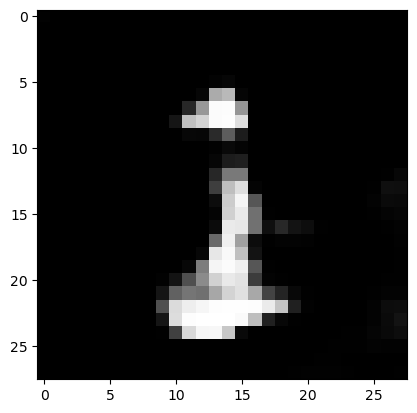

In [25]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = generator.predict(noise)

# rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.show()
